In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
# %matplotlib

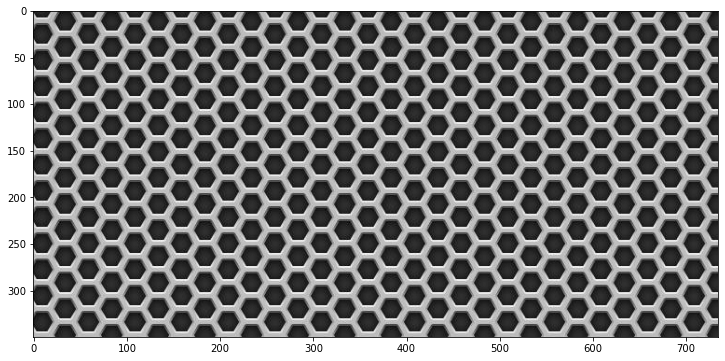

In [2]:
metalgrid = cv2.imread('./images/metalgrid.jpg')
gray = cv2.cvtColor(metalgrid, cv2.COLOR_BGR2GRAY)
fig = plt.figure(figsize=(15,6)), plt.imshow(gray,cmap = 'gray')

In [3]:
def get_color(color):
    if color=='r':
        return 0
    if color=='g':
        return 1
    if color=='b':
        return 2
    return 0

def find_border(img,angles,tolereance=10,percentil=0,colors=['r']):
    if len(colors)!=len(angles):
        if len(colors)==1: 
            colors = np.repeat(colors,len(angles))
        else:
            raise ValueError("len(color) must match with len(angles) or be equal to 1")
            
    # Blur image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(5,5),0)

    # Apply Sobelx in 'float32' and convert to 8-bits to avoid overflow
    sobelx_64 = cv2.Sobel(blur,cv2.CV_32F,1,0,ksize=3)
    absx_64 = np.absolute(sobelx_64)
    sobelx_8u1 = (absx_64/absx_64.max())*255
    sobelx_8u = np.uint8(sobelx_8u1)

    # Apply Sobely in 'float32' and convert to 8-bits to avoid overflow
    sobely_64 = cv2.Sobel(blur,cv2.CV_32F,0,1,ksize=3)
    absy_64 = np.absolute(sobely_64)
    sobely_8u1 = (absy_64/absy_64.max())*255
    sobely_8u = np.uint8(sobely_8u1)

    # Calculate magnitude and convert to 8-bit
    mag = np.hypot(sobelx_8u, sobely_8u)
    mag = (mag/mag.max())*255
    mag = np.uint8(mag)

    # Find direction
    theta = np.arctan2(sobely_64, sobelx_64)
    angle = np.rad2deg(theta)

    # Repeat for each couple of angles
    max_pixel_value = np.iinfo(img.dtype).max
    paint = np.zeros(img.shape,dtype=img.dtype)
    for ang,color in zip(angles,colors):
        # Create mask between min-max angles and apply mask to magnitude value
        max_angle = ang + tolereance
        min_angle = ang - tolereance
        mask_angle = (angle>min_angle)*(angle<max_angle)
        masked_mag = mag*mask_angle

        # In masked magnitude, apply mask for values greater than percentil value
        perc_val = np.percentile(masked_mag, percentil)
        mask_mag = (mag>=perc_val)*mask_angle
        # new_img = np.ones(img.shape[:2])*mask_mag
        
        # Add to paint matrix with the corresponding color
        inx_color = get_color(color)
        paint[:,:,inx_color] = paint[:,:,inx_color] + (np.ones(paint.shape[:2])*mask_mag)*max_pixel_value
        
    return cv2.addWeighted(img, 0.4, paint, 1, 0)
        

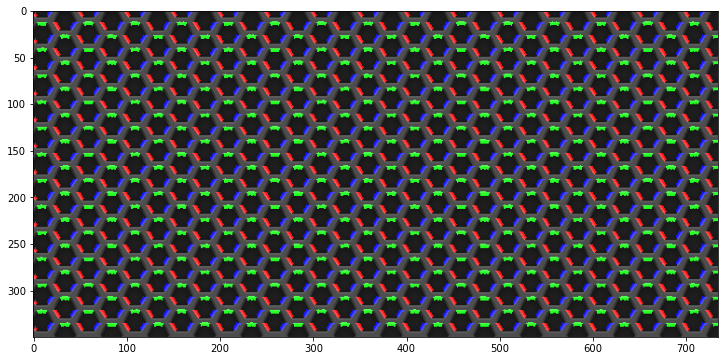

In [4]:
angles = [145,-90,30]
colors=['r','g','b']
img_out = find_border(metalgrid,angles,tolereance=10,colors=colors,percentil=95)
fig = plt.figure(figsize=(15,6)), plt.imshow(img_out)

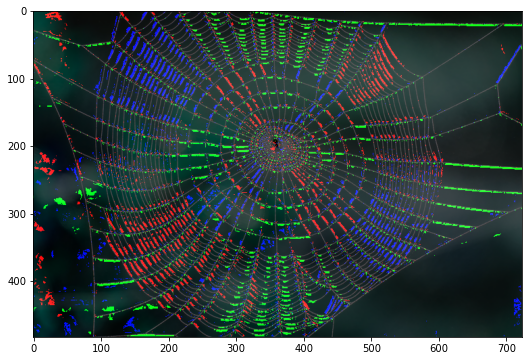

In [8]:
img = cv2.imread('./images/tela2.jpg')
angles = [145,-90,30]
colors=['r','g','b']
img_out = find_border(img,angles,tolereance=10,colors=colors,percentil=97)
fig = plt.figure(figsize=(15,6)), plt.imshow(img_out)